## Putting it all together

In [32]:
import seaborn as sns; sns.set_style("dark")
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler, Normalizer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import janitor
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.feature_selection import RFECV
import numpy as np

In [33]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [34]:
train.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,806407308,Attrited Customer,54,F,3,College,Single,Unknown,Blue,49,...,2,3,13184.0,0,13184.0,1.166,2047,33,0.179,0.000
1,801786483,Existing Customer,51,M,0,High School,Single,$80K - $120K,Blue,45,...,2,3,10648.0,2517,8131.0,0.708,4930,89,0.978,0.236
2,779870883,Existing Customer,45,F,4,High School,Single,$40K - $60K,Blue,29,...,2,1,4595.0,1781,2814.0,0.708,3746,68,0.545,0.388
3,720336708,Existing Customer,53,M,3,Doctorate,Married,$40K - $60K,Blue,35,...,3,2,3789.0,1706,2083.0,1.047,1609,42,0.680,0.450
4,716769783,Existing Customer,48,F,2,Graduate,Married,Unknown,Blue,40,...,2,4,5104.0,736,4368.0,0.679,3943,78,0.696,0.144


In [35]:
test.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,720943308,Existing Customer,47,M,3,Graduate,Single,$60K - $80K,Silver,36,...,1,2,30498.0,1990,28508.0,0.839,16202,120,0.791,0.065
1,710879283,Existing Customer,51,M,1,High School,Married,Less than $40K,Blue,41,...,4,3,1438.3,0,1438.3,0.623,4312,81,0.723,0.000
2,787800108,Existing Customer,55,M,2,College,Married,$80K - $120K,Blue,45,...,1,2,2929.0,2431,498.0,1.632,1903,39,0.625,0.830
3,789200208,Existing Customer,40,F,4,Uneducated,Married,Unknown,Blue,29,...,3,3,3326.0,2181,1145.0,0.827,13583,110,0.746,0.656
4,711332883,Attrited Customer,62,M,1,High School,Single,$60K - $80K,Blue,46,...,3,3,7547.0,2477,5070.0,1.021,5294,73,0.698,0.328


In [36]:
train, val = train_test_split(train, random_state = 42, train_size = 0.8, stratify = train["attrition_flag"])

### Hardcoded Feature Engineering

In [37]:
train["revolving_trans"] = train["total_revolving_bal"]/train["total_trans_amt"]
val["revolving_trans"] = val["total_revolving_bal"]/val["total_trans_amt"]
test["revolving_trans"] = test["total_revolving_bal"]/test["total_trans_amt"]

In [38]:
train["marriage_education"] = train["marital_status"] + "_" + train["education_level"]
val["marriage_education"] = val["marital_status"] + "_" + val["education_level"]
test["marriage_education"] = test["marital_status"] + "_" + test["education_level"]

In [39]:
train["attrition_flag"] = train["attrition_flag"].replace(["Attrited Customer","Existing Customer"], [1,0]).astype(int)
test["attrition_flag"] = test["attrition_flag"].replace(["Attrited Customer","Existing Customer"], [1,0]).astype(int)
val["attrition_flag"] = val["attrition_flag"].replace(["Attrited Customer","Existing Customer"], [1,0]).astype(int)

### Data deduplication

In [40]:
train_0 = train[train["attrition_flag"] == 0]
train_0.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education
6694,716389833,0,50,F,1,Unknown,Single,Less than $40K,Blue,40,...,2319.0,1026,1293.0,0.521,4099,74,0.721,0.442,0.250305,Single_Unknown
6698,787430733,0,56,F,2,High School,Married,$40K - $60K,Blue,41,...,2771.0,1446,1325.0,0.686,1706,27,0.227,0.522,0.847597,Married_High School
5560,719539458,0,46,F,3,Graduate,Single,Less than $40K,Blue,41,...,3913.0,0,3913.0,0.722,5170,93,0.860,0.000,0.000000,Single_Graduate
2893,716791908,0,43,M,1,College,Married,$80K - $120K,Blue,23,...,14566.0,1045,13521.0,0.417,4480,77,0.791,0.072,0.233259,Married_College
796,709562358,0,55,F,2,Unknown,Single,Less than $40K,Blue,43,...,5353.0,1594,3759.0,0.973,4456,79,0.837,0.298,0.357720,Single_Unknown


In [41]:
train_1 = train[train["attrition_flag"] == 1]
train_1.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education
6982,715150983,1,44,F,3,Unknown,Single,Unknown,Blue,34,...,26021.0,0,26021.0,1.040,8898,60,0.538,0.000,0.000000,Single_Unknown
859,814483608,1,47,F,4,Graduate,Divorced,Less than $40K,Blue,42,...,5798.0,2517,3281.0,0.580,1860,43,0.433,0.434,1.353226,Divorced_Graduate
390,719894433,1,43,F,4,Unknown,Married,Less than $40K,Blue,24,...,1679.0,951,728.0,0.706,2492,43,0.593,0.566,0.381621,Married_Unknown
1028,711249858,1,49,M,4,Unknown,Married,$80K - $120K,Blue,38,...,29890.0,0,29890.0,0.640,3315,47,0.382,0.000,0.000000,Married_Unknown
2264,718352358,1,49,F,3,Post-Graduate,Married,Less than $40K,Blue,35,...,1914.0,0,1914.0,0.677,2687,41,0.414,0.000,0.000000,Married_Post-Graduate


In [42]:
train_0 = train_0.drop_duplicates()

### Class balancing

In [43]:
rand_list = list(np.random.randint(0, len(train_0), len(train_1)))

In [44]:
train_0 = train_0.iloc[rand_list,]
train_0.shape

(1041, 23)

In [45]:
train_new = pd.concat([train_0, train_1], axis = 0)
train_new.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education
3913,792300858,0,44,F,3,Graduate,Divorced,$40K - $60K,Blue,38,...,4269.0,1852,2417.0,0.682,4178,75,0.630,0.434,0.443274,Divorced_Graduate
6803,789338583,0,42,M,2,Doctorate,Married,$80K - $120K,Blue,32,...,26222.0,1073,25149.0,1.288,1988,30,0.579,0.041,0.539738,Married_Doctorate
6028,708119658,0,49,F,4,Graduate,Married,$40K - $60K,Blue,38,...,12836.0,1034,11802.0,0.663,2519,53,0.472,0.081,0.410480,Married_Graduate
4114,721385433,0,64,M,0,Unknown,Married,Less than $40K,Blue,51,...,2787.0,1201,1586.0,0.372,1662,39,0.625,0.431,0.722623,Married_Unknown
2322,719848908,0,41,F,3,Graduate,Married,Unknown,Blue,33,...,2542.0,0,2542.0,0.587,4087,73,0.780,0.000,0.000000,Married_Graduate


### Splitting into independent and dependent variables

In [46]:
x_train, y_train = train_new.drop(['attrition_flag','gender','clientnum'], axis = 1), train_new["attrition_flag"]

In [16]:
x_val, y_val = val.drop(['attrition_flag','gender','clientnum'], axis = 1), val["attrition_flag"]

In [17]:
x_test, y_test = test.drop(['attrition_flag','gender','clientnum'], axis = 1), test["attrition_flag"]

### Gathering categorical and numerical columns

In [18]:
num = []
cat = []
columns = list(x_train.columns)
for col in columns:
    if is_numeric_dtype(x_train[col]):
        num.append(col)
    elif is_string_dtype(x_train[col]):
        cat.append(col)

### Preprocessing tools

In [19]:
one_hot = OneHotEncoder()
min_max = MinMaxScaler()
sd = StandardScaler()
le = LabelEncoder()

In [20]:
ct = ColumnTransformer([("one_hot", one_hot, cat), ("min_max", min_max, num)])

### Pipeline Creation

In [21]:
pipeline = Pipeline([("ct", ct), ("rfe", RFECV(Lasso())), ("nb", GaussianNB())])

### Fitting pipeline on training data

In [22]:
model = pipeline.fit(x_train, y_train)

### Evaluating pipeline's accuracy

#### Training data results

In [23]:
pred_train = model.predict(x_train)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1041
           1       0.70      0.65      0.68      1041

    accuracy                           0.69      2082
   macro avg       0.69      0.69      0.69      2082
weighted avg       0.69      0.69      0.69      2082



<AxesSubplot:>

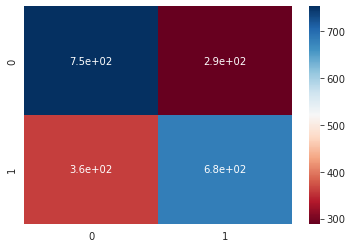

In [24]:
conf = confusion_matrix(y_train, pred_train)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [25]:
train_new["prediction"] = pred_train
train_probs = model.predict_proba(x_train)
train_new["prob_0"], train_new["prob_1"] = train_probs[:,0], train_probs[:,1]
train_new.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education,prediction,prob_0,prob_1
6240,771237933,0,47,M,1,Uneducated,Unknown,$80K - $120K,Blue,34,...,1.276,1477,23,0.533,0.053,0.734597,Unknown_Uneducated,0,0.576931,0.423069
5347,712470033,0,44,F,3,College,Single,Less than $40K,Blue,30,...,0.705,2960,67,0.861,0.452,0.693581,Single_College,0,0.580288,0.419712
5805,770926158,0,51,F,0,Doctorate,Single,Less than $40K,Blue,38,...,0.786,13820,129,0.697,0.609,0.182127,Single_Doctorate,0,0.534088,0.465912
7134,710035008,0,31,F,0,Uneducated,Single,Less than $40K,Blue,24,...,0.880,2491,64,1.000,0.365,0.560819,Single_Uneducated,0,0.583999,0.416001
7690,715543908,0,52,F,3,Uneducated,Married,Less than $40K,Blue,43,...,0.653,1352,37,0.370,0.546,0.867604,Married_Uneducated,0,0.558756,0.441244


#### Validation Data results

In [26]:
pred_val = model.predict(x_val)
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1360
           1       0.29      0.61      0.39       261

    accuracy                           0.69      1621
   macro avg       0.60      0.66      0.59      1621
weighted avg       0.81      0.69      0.73      1621



<AxesSubplot:>

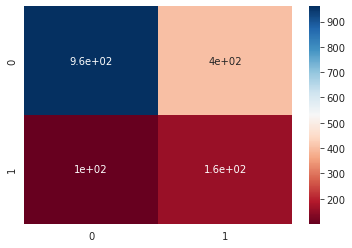

In [27]:
conf = confusion_matrix(y_val, pred_val)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [28]:
val["prediction"] = pred_val
val_probs = model.predict_proba(x_val)
val["prob_0"], val["prob_1"] = val_probs[:,0], val_probs[:,1]
val.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education,prediction,prob_0,prob_1
5423,788916933,0,49,M,5,College,Married,$60K - $80K,Gold,35,...,0.796,8095,81,0.620,0.031,0.131439,Married_College,0,0.520434,0.479566
4059,711452583,0,43,F,4,Graduate,Unknown,Unknown,Blue,36,...,0.796,4575,60,0.714,0.906,0.550164,Unknown_Graduate,0,0.583824,0.416176
1076,710780883,0,48,F,5,Uneducated,Single,$40K - $60K,Blue,38,...,0.860,4610,78,0.773,0.597,0.316920,Single_Uneducated,0,0.562294,0.437706
1295,719326758,1,52,F,0,Doctorate,Married,Less than $40K,Blue,36,...,0.945,9226,85,1.073,0.342,0.161392,Married_Doctorate,0,0.528704,0.471296
4485,708907833,0,38,F,1,High School,Single,Unknown,Blue,27,...,0.851,7866,84,0.909,0.101,0.319985,Single_High School,0,0.562799,0.437201


#### Test data results

In [29]:
pred_test = model.predict(x_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1701
           1       0.31      0.64      0.42       325

    accuracy                           0.71      2026
   macro avg       0.61      0.68      0.61      2026
weighted avg       0.82      0.71      0.75      2026



<AxesSubplot:>

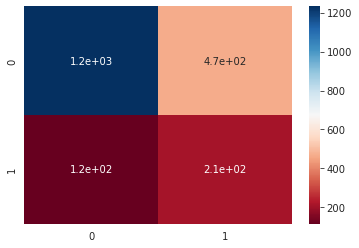

In [30]:
conf = confusion_matrix(y_test, pred_test)
sns.heatmap(conf, annot = True, cmap = "RdBu")

In [31]:
test["prediction"] = pred_test
test_probs = model.predict_proba(x_test)
test["prob_0"], test["prob_1"] = test_probs[:,0], test_probs[:,1]
test.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,revolving_trans,marriage_education,prediction,prob_0,prob_1
0,720943308,0,47,M,3,Graduate,Single,$60K - $80K,Silver,36,...,0.839,16202,120,0.791,0.065,0.122824,Single_Graduate,0,0.517947,0.482053
1,710879283,0,51,M,1,High School,Married,Less than $40K,Blue,41,...,0.623,4312,81,0.723,0.000,0.000000,Married_High School,1,0.477339,0.522661
2,787800108,0,55,M,2,College,Married,$80K - $120K,Blue,45,...,1.632,1903,39,0.625,0.830,1.277457,Married_College,1,0.431706,0.568294
3,789200208,0,40,F,4,Uneducated,Married,Unknown,Blue,29,...,0.827,13583,110,0.746,0.656,0.160568,Married_Uneducated,0,0.528484,0.471516
4,711332883,1,62,M,1,High School,Single,$60K - $80K,Blue,46,...,1.021,5294,73,0.698,0.328,0.467888,Single_High School,0,0.580111,0.419889
